# Manual Testing

This file is designed to load in the saved models trained by main.py and evaluate them

In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr import algo, utils
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from evaluation import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt

def load_model(algo='ppo', env=None, filename=None):
    '''
    Load a trained model from the algorithm
    '''
    if env is None and filename is None:
        raise
    file = 'trained_models/' + algo + '/'
    if env is not None:
        file = file + env + '.pt'
    elif filename is not None:
        file = file + filename
        
    model, rms = torch.load(file)

    return model, rms
    
%run model_evaluation

# Test running a single model and running Policy, FlexBase

In [ ]:
%run model_evaluation

model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_c4_auxwall1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


obs, rnn_hxs, masks = results['obs'][0], results['hidden_states'][0], results['masks'][0]

import sys
sys.path.append('../')
from a2c_ppo_acktr.model import Policy

env = gym.make('NavEnv-v0', **kwargs)

model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0, 'auxiliary_heads': [[-1, 0, 1]]})
# model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0})

# model, obs_rms, kwargs = load_model_and_env('nav_invisible_shared/nav_c4_shared0.dist', 0)
action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


In [6]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks2/nav_c4_auxeuclid0', 0)
env = gym.make('NavEnv-v0', **kwargs)

In [18]:
def quick_vec_env(obs_rms, env_kwargs={}, env_name='NavEnv-v0', seed=0,
                 num_processes=1, eval_log_dir='/tmp/gym/_eval',
                 device=torch.device('cpu'), capture_video=False):
    eval_envs = make_vec_envs(env_name, seed + num_processes, num_processes,
                          None, eval_log_dir, device, True, 
                          capture_video=capture_video, 
                          env_kwargs=env_kwargs)

    vec_norm = utils.get_vec_normalize(eval_envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms
        
    return eval_envs


**Test making vec_envs and policy**

In [71]:
kwargs = {
    'task_structure': 4,
    'rew_structure': 'goal',
    'num_objects': 0,
    'wall_colors': 1,
    'poster': 1,
    'num_rays': 12,
    'fov': 1
}

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 4, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, #distal
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)

{'value': tensor([[-0.0015]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[ 0.0005,  0.0024,  0.0019, -0.0011]], grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[ 0.0007, -0.0013,  0.0007,  0.0003]], grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.]]),
 'action': tensor([[1]]),
 'action_log_probs': tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>)}

In [72]:
model.evaluate_actions(obs, rnn_hxs, masks, torch.tensor([[1]]))

(tensor([[-0.0015]], grad_fn=<AddmmBackward0>),
 tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>),
 tensor(1.3863, grad_fn=<MeanBackward0>),
 tensor([[ 0.0007, -0.0013,  0.0007,  0.0003]], grad_fn=<SqueezeBackward1>),
 tensor([[0.]]))

## Example: Test Correlated 2-arm Bandits

In [2]:
# env_name = 'CartPole-v1'
env_name = 'Bandits-v0'
model, rms = load_model(env=env_name, algo='a2c')
log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")


In [3]:
all_obs, all_actions, all_rewards, all_hidden_states, eval_envs = evaluate(model, rms, env_name, 1, 10, log_dir, device)

 Evaluation using 10 episodes: mean reward 77.30000



In [4]:
all_obs2 = torch.zeros(size=[len(all_obs)] + list(all_obs[0].shape))
all_actions2 = torch.zeros(size=[len(all_actions)] + list(all_actions[0].shape))
all_rewards2 = torch.zeros(size=[len(all_rewards)] + list(all_rewards[0].shape))
all_hidden_states2 = torch.zeros(size=[len(all_hidden_states)] + list(all_hidden_states[0].shape))

for i in range(len(all_obs)):
    all_obs2[i] = all_obs[i]
    all_actions2[i] = all_actions[i]
    all_rewards2[i] = all_rewards[i]
    all_hidden_states2[i] = all_hidden_states[i]

In [7]:
reward_probabilities = eval_envs.get_attr('reward_probabilities')

In [19]:
second_arm_probs = []
second_arm_choices = []
for i in range(all_actions2.shape[1]):
    second_arm_choices.append(torch.mean(all_actions2.T[0][i]))
    second_arm_probs.append(reward_probabilities[i][1])

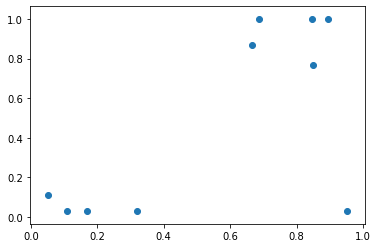

In [21]:
plt.scatter(second_arm_probs, second_arm_choices)

In [24]:
env = gym.make('Bandits-v0', num_arms=3)

In [29]:
env.step(2)

(array([0., 0., 1., 1., 5.]), 1, False, {})

In [30]:
env.reward_probabilities

array([0.32455324, 0.33017026, 0.3452765 ])

## Test Goal Dist Auxiliary Task

In [2]:
%run representation_analysis
%run model_evaluation

In [51]:

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 2, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, 'auxiliary_tasks': [3, 2], 'auxiliary_task_args': [None, 4],
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4, 'auxiliary_heads': [[-1, 0, 1]]})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)
envs.step(torch.tensor([[1]]))

(tensor([[ 0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,
           0.0012,  0.0012,  0.0012,  0.0012, -0.7812, -0.7854, -0.7913, -0.7990,
          -0.8084, -0.8194, -0.8318, -0.8455, -0.8601, -0.8753, -0.7181, -0.7047]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([0.39090402, 0.29447325])}])

In [35]:
envs.step(torch.tensor([[1]]))

(tensor([[ 4.9541e-04,  4.9541e-04,  4.9541e-04,  4.9541e-04,  4.9541e-04,
           4.9541e-04,  4.9541e-04,  4.9541e-04,  4.9541e-04,  4.9541e-04,
           4.9541e-04,  4.9541e-04, -1.5789e+00, -1.5790e+00, -1.5791e+00,
          -1.5792e+00, -1.5793e+00, -1.5795e+00, -1.5796e+00, -1.5798e+00,
          -1.5800e+00, -1.5801e+00, -1.8051e+00, -1.6492e+00]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([0.43628051])}])

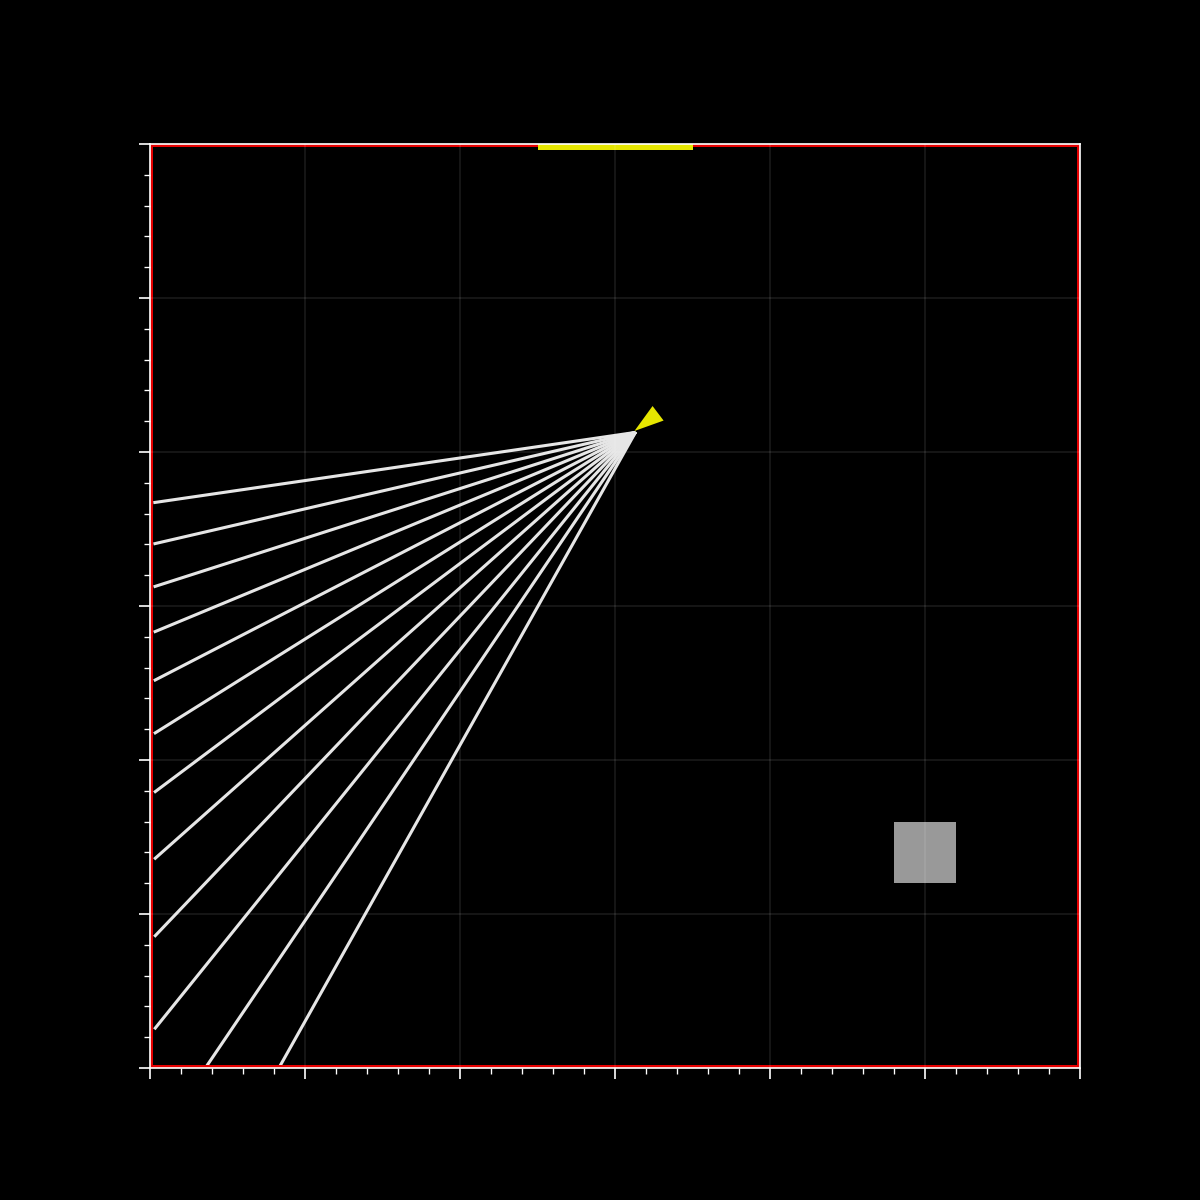

In [49]:
envs.get_attr('render')[0]()

In [36]:
np.linalg.norm(envs.get_attr('character')[0].pos - envs.get_attr('boxes')[0][-1].center)

185.09814297225236

[250.0, 70.0]

# Manual Testing of Training Code

In [74]:
from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

In [36]:

vec_norm = utils.get_vec_normalize(envs)

In [95]:

from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
import torch
from collections import deque

#Overall training params
num_steps = 10 #batch steps
num_processes = 1
env_name = 'NavEnv-v0'
seed = 0
gamma = 0.99
log_dir = '/tmp/gym/'
device = torch.device('cpu')
capture_video = False

#Training update step params
use_gae = False
gae_lambda = 0.95

#Agent update params
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1 #how many minibatches to divide our num_steps*num_processes batch of rollouts into
value_loss_coef = 0.5
entropy_coef = 0.01
auxiliary_loss_coef = 0.3
lr = 7e-4
eps = 1e-5
max_grad_norm = 0.5


num_updates = 1 #total batch_size updates to do

# episode_rewards = deque(maxlen=10)
agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts, use_gae=use_gae, gamma=gamma, gae_lambda=gae_lambda)


In [28]:
import sys
sys.path.append('..')
from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
from  a2c_ppo_acktr.model import Policy
import torch
from collections import deque

'''
First 4 parameters are for shared recurrent layer. Can freeze these by setting
requires_grad = False
'''

def populate_rollouts(model, envs, rollouts, num_steps):
    for step in range(num_steps):
        #Generate rollouts for num_steps batch
        with torch.no_grad():
            outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                                rollouts.masks[step])
            action = outputs['action']
            value = outputs['value']
            action_log_prob = outputs['action_log_probs']
            recurrent_hidden_states = outputs['rnn_hxs']
            # auxiliary_preds = outputs['auxiliary_preds']

        obs, reward, done, infos = envs.step(action)

        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

        
def update_model(agent, rollouts, use_gae=False, gamma=0.99, gae_lambda=0.95,
                 after_update=True):
    
    #Compute last value to be used for the update
    with torch.no_grad():
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()
    
    rollouts.compute_returns(next_value, use_gae, gamma, gae_lambda)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
    
    if after_update:
        rollouts.after_update()
        
    return value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss


def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBase', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False):
    
    #Initialize vectorized environments
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)

    if model is None:
        model = Policy(envs.observation_space.shape,
                       envs.action_space,
                       base='FlexBase',
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    agent = algo.PPO(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm)


    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    vec_norm = utils.get_vec_normalize(envs)
    if vec_norm is not None and obs_rms is not None:
        vec_norm.obs_rms = obs_rms


    #Initialize storage
    rollouts = RolloutStorage(num_steps, num_processes, envs.observation_space.shape, envs.action_space,
                              model.recurrent_hidden_state_size, model.auxiliary_output_size)
    #Storage objects initializes a bunch of empty tensors to store information, e.g.
    #obs has shape (num_steps+1, num_processes, obs_shape)
    #rewards has shape (num_steps, num_processes, 1)

    #obs, recurrent_hidden_states, value_preds, returns all have batch size num_steps+1
    #rewards, action_log_probs, actions, masks, auxiliary_preds, auxiliary_truths all have batch size num_steps
    obs = envs.reset()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    return agent, envs, rollouts

In [27]:
'''
Testing freezing params

We load a trained model, freeze the recurrent layer and train, showing that indeed parameters
besides the recurrent layer have updated
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

params = list(model.parameters())
temp_param_vals = []
for i in range(4):
    params[i].requires_grad=False
for i in range(len(params)):
    temp_param_vals.append(params[i].data.clone())
# list(model.parameters())[0].requires_grad=False



num_updates = 1 #total batch_size updates to do
num_steps = 10

agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts)
    
for i in range(len(params)):
    print(temp_param_vals[i].squeeze()[0] - params[i].data.squeeze()[0]) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
tensor(0.)
tensor([ 0.0020, -0.0001,  0.0021, -0.0019, -0.0016, -0.0021, -0.0022,  0.0019,
         0.0021,  0.0023, -0.0017, -0.0019,  0.0021, -0.0025, -0.0020, -0.0021,
        -0.0022,  0.0023,  0.0022, -0.0021, -0.0022,  0.0022, -0.0020,  0.0019,
        -0.0021, -0.0021, -0.0019, -0.0023,  0.0024, -0.0020, -0.0025,  0.0023,
        -0.0021,  0.0019,  0.0023,  0.0023,  0.0022,  0.0025, -0.0024,  0.0020,
         0.0022, -0.0021,  0.0018,  0.0020,  0.0022, -0.0021,  0.0020, -0.0020,
         0.0018,  0.0023,  0.0021, -0.0019,  0.0016,  0.0023, -0.0018,  0.0020,
        -0.0017, -0.0018, -0.002

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

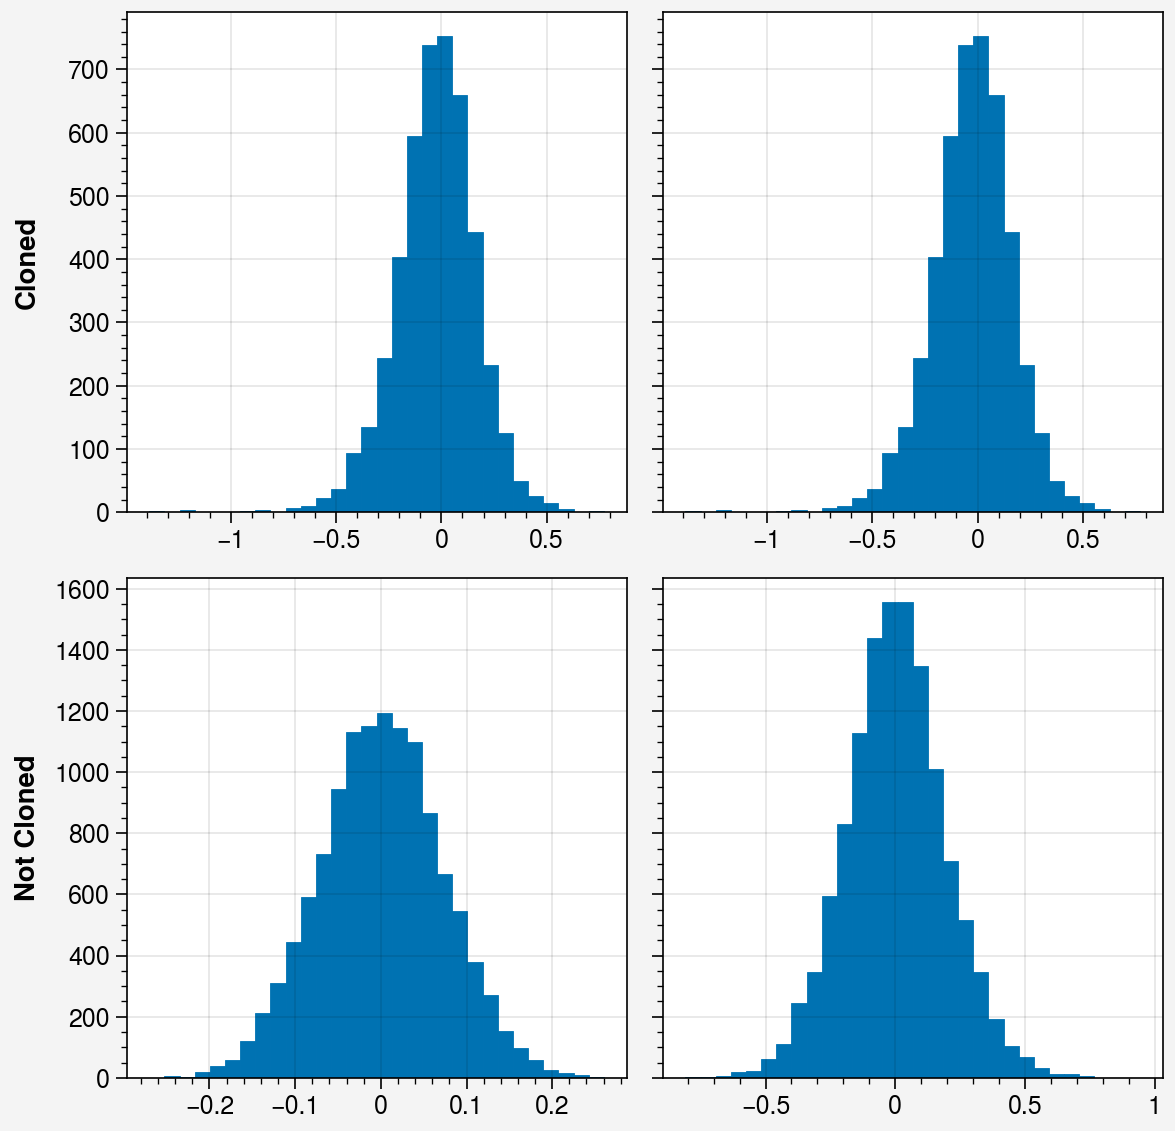

In [81]:
'''
Testing cloning params

We initiate a new model and then clone the first set of parameters from a trained model onto it
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs)



import matplotlib.pyplot as plt
import proplot as pplt

fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False)
ax.format(leftlabels=['Cloned', 'Not Cloned'])
params1 = list(agent.actor_critic.parameters())
params2 = list(model.parameters())

params1[0].data.copy_(params2[0].data)

for i in range(2):
    ax[i, 0].hist(params1[i].reshape(-1).detach().numpy(), bins=30)
    ax[i, 1].hist(params2[i].reshape(-1).detach().numpy(), bins=30)

In [75]:
list(model.parameters())[0].requires_grad=False

In [11]:
model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

list(model.parameters())[0]

Parameter containing:
tensor([[-0.2363, -0.1641, -0.2136,  ..., -0.0875, -0.0453,  0.0504],
        [ 0.0946,  0.1231,  0.0256,  ...,  0.1203,  0.4508,  0.4429],
        [ 0.0444,  0.1615,  0.0574,  ..., -0.0182, -0.1240, -0.2136],
        ...,
        [ 0.0231,  0.0861, -0.0638,  ...,  0.0427, -0.0582, -0.4408],
        [-0.0795, -0.0732, -0.0005,  ...,  0.0230, -0.0275,  0.0313],
        [ 0.3718,  0.0880,  0.1137,  ..., -0.0081, -0.0256,  0.0841]],
       requires_grad=True)

In [47]:
for param in model.parameters():
    print(param.shape)

torch.Size([192, 24])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])
torch.Size([4, 64])
torch.Size([4])


In [50]:
list(model.parameters())[0].requires_grad = False

In [52]:
list(model.parameters())[0].requires_grad

False

In [25]:
test.append(6)

In [26]:
test

deque([4, 4, 5, 5, 6])

# Manual Testing of scheduler reader and main

In [5]:
%run ../testargs

convert_config_to_command('nav_pdistal_width16clone1_t0', config_folder='../experiment_configs/')

'python main.py --wandb-project-name Nav_Shared_Layers --exp-name nav_pdistal_width16clone1_t0 --save-name nav_pdistal_width16clone1_t0 --num-env-steps 5000000 --env-name NavEnv-v0 --algo ppo --num-mini-batch 1 --num-processes 1 --num-steps 200 --checkpoint-interval 10 --recurrent --seed 0 --no-cuda --env-kwargs num_objects=0 rew_structure=goal task_structure=2 wall_colors=1 num_rays=12 fov=1 poster=1 character_reset_pos=1 --nn-base FlexBase --nn-base-kwargs hidden_size=16 --clone-parameter-experiment --clone-args clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt clone_layers=4 freeze=True --config-file-name nav_pdistal_width16clone1_t0 '

In [6]:
%run ../testargs --wandb-project-name Nav_Shared_Layers --exp-name nav_pdistal_width16clone1_t0 --save-name nav_pdistal_width16clone1_t0 --num-env-steps 5000000 --env-name NavEnv-v0 --algo ppo --num-mini-batch 1 --num-processes 1 --num-steps 200 --checkpoint-interval 10 --recurrent --seed 0 --no-cuda --env-kwargs num_objects=0 rew_structure=goal task_structure=2 wall_colors=1 num_rays=12 fov=1 poster=1 character_reset_pos=1 --nn-base FlexBase --nn-base-kwargs hidden_size=16 --clone-parameter-experiment --clone-args clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt clone_layers=4 freeze=True --config-file-name nav_pdistal_width16clone1_t0

['num_objects=0', 'rew_structure=goal', 'task_structure=2', 'wall_colors=1', 'num_rays=12', 'fov=1', 'poster=1', 'character_reset_pos=1']
['hidden_size=16']
['clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt', 'clone_layers=4', 'freeze=True']


In [3]:
import copy
import glob
import os
import time
from collections import deque
from shutil import copyfile

import gym
import gym_nav
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate

from scheduler import write_latest_exp_complete

ModuleNotFoundError: No module named 'evaluation'

In [27]:
device = torch.device("cuda:0" if args.cuda else "cpu")
print('initializing environments')
envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                     args.gamma, args.log_dir, device, False, capture_video=args.capture_video,
                     env_kwargs=args.env_kwargs)

loaded_model = False
# print(args.cont)
print('initializing model')
print(args.save_interval)

#Andy: for continuing an experiment, args.cont is True
if args.cont:
    loaded_model = True
    actor_critic, obs_rms = torch.load(save_path)

if not loaded_model:
    actor_critic = Policy(
        envs.observation_space.shape,
        envs.action_space,
        base=args.nn_base,
        base_kwargs={'recurrent': args.recurrent_policy, 
                     **args.nn_base_kwargs})

    #Andy: if cloning parameters, do it here. We are assuming
    #that the target cloning network has the appropriate parameter
    #sizes
    if args.clone_parameter_experiment:
        clone_args = args.clone_args
        clone_actor_critic, obs_rms = torch.load(clone_args['clone_path'])
        clone_layers = clone_args['clone_layers']
        freeze_layers = clone_args['freeze']

        clone_params = list(clone_actor_critic.parameters())
        actor_critic_params = list(actor_critic.parameters())

        if type(clone_layers) == int:
            clone_layers = range(clone_layers)
        if type(freeze_layers) == bool:
            freeze_layers = [freeze_layers]*len(clone_layers)
        for i, layer in enumerate(clone_layers):
            freeze = freeze_layers[i]

            actor_critic_params[layer].data.copy_(clone_params[layer].data)
            if freeze:
                actor_critic_params[layer].requires_grad = False

    actor_critic.to(device)

initializing environments
initializing model
100


In [29]:
[params.reshape(-1)[0] for params in actor_critic_params]

[tensor(-0.1996),
 tensor(0.0540),
 tensor(0.1136),
 tensor(0.1136),
 tensor(-0.4285, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0.1263, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(-0.5297, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0.0190, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0.3803, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0.0024, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>)]

In [30]:
[params.reshape(-1)[0] for params in clone_params]

[tensor(-0.1996, grad_fn=<SelectBackward0>),
 tensor(0.0540, grad_fn=<SelectBackward0>),
 tensor(0.1136, grad_fn=<SelectBackward0>),
 tensor(0.1136, grad_fn=<SelectBackward0>),
 tensor(-0.2849, grad_fn=<SelectBackward0>),
 tensor(0.0846, grad_fn=<SelectBackward0>),
 tensor(-0.2403, grad_fn=<SelectBackward0>),
 tensor(0.0673, grad_fn=<SelectBackward0>),
 tensor(0.4290, grad_fn=<SelectBackward0>),
 tensor(-0.1930, grad_fn=<SelectBackward0>),
 tensor(0.6229, grad_fn=<SelectBackward0>),
 tensor(0.0408, grad_fn=<SelectBackward0>),
 tensor(-0.0314, grad_fn=<SelectBackward0>),
 tensor(0.3039, grad_fn=<SelectBackward0>),
 tensor(0.0918, grad_fn=<SelectBackward0>),
 tensor(0.0998, grad_fn=<SelectBackward0>)]

In [16]:
[params.shape for params in actor_critic_params]

[torch.Size([48, 24]),
 torch.Size([48, 16]),
 torch.Size([48]),
 torch.Size([48]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([1, 16]),
 torch.Size([1]),
 torch.Size([4, 16]),
 torch.Size([4])]

In [17]:
[params.shape for params in clone_params]

[torch.Size([48, 24]),
 torch.Size([48, 16]),
 torch.Size([48]),
 torch.Size([48]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([1, 16]),
 torch.Size([1]),
 torch.Size([4, 16]),
 torch.Size([4])]

In [24]:
actor_critic_params[0].data.copy_(clone_params[0].data)

tensor([[-0.1996, -0.0616,  0.0755,  ...,  0.3947,  0.2309, -0.5053],
        [ 0.3225,  0.3477,  0.2927,  ...,  0.1383,  0.0856, -0.2380],
        [-0.3253, -0.3571, -0.1839,  ...,  0.0409,  0.0971, -0.0380],
        ...,
        [-0.1191, -0.0896, -0.0520,  ...,  0.1945, -0.0092,  0.5069],
        [ 0.2235,  0.3383,  0.0207,  ..., -0.0743,  0.1591,  0.1812],
        [ 0.2866,  0.0089,  0.0020,  ...,  0.3050,  0.1600,  0.2031]])

In [26]:
actor_critic_params[0].requires_grad = False

In [23]:
actor_critic_params[0].data

tensor([[ 0.0814,  0.2402,  0.1176,  ...,  0.0748, -0.0588, -0.2830],
        [ 0.0721, -0.0275, -0.0505,  ..., -0.0927, -0.0470,  0.1332],
        [-0.0504, -0.1441,  0.1046,  ...,  0.2720,  0.1938,  0.0620],
        ...,
        [-0.1662, -0.2452, -0.0177,  ...,  0.0896, -0.3231, -0.0479],
        [ 0.0427, -0.1586,  0.2644,  ...,  0.1270, -0.0768,  0.1847],
        [ 0.0902, -0.3336, -0.1938,  ...,  0.0267,  0.0887,  0.1183]])

In [22]:
actor_critic_params[0]

Parameter containing:
tensor([[ 0.0814,  0.2402,  0.1176,  ...,  0.0748, -0.0588, -0.2830],
        [ 0.0721, -0.0275, -0.0505,  ..., -0.0927, -0.0470,  0.1332],
        [-0.0504, -0.1441,  0.1046,  ...,  0.2720,  0.1938,  0.0620],
        ...,
        [-0.1662, -0.2452, -0.0177,  ...,  0.0896, -0.3231, -0.0479],
        [ 0.0427, -0.1586,  0.2644,  ...,  0.1270, -0.0768,  0.1847],
        [ 0.0902, -0.3336, -0.1938,  ...,  0.0267,  0.0887,  0.1183]],
       requires_grad=True)

In [12]:
actor_critic_params[layer].shape

torch.Size([48, 16])